# Convert results of Adumusulli et al., 2020 to xarray and upload to ldeo-glaciology google bucket
Data can be found and downloaded here: https://library.ucsd.edu/dc/object/bb0448974g

Paper can be found here: https://www.nature.com/articles/s41561-020-0616-z

Code to plot figures from the paper can be found here: https://github.com/sioglaciology/ice_shelf_change

In [1]:
import h5py
import numpy as np
import xarray as xr
import json
import gcsfs
import os

rho_ow = 1028   # density of ocean water
rho_ice = 917   # density of ice

## load melt rate data from h5 file. 

In [2]:
filepath = '/Users/dporter/data/Antarctic/melt'
filename ='bb0448974g_3_1.h5'
is_wb = h5py.File(os.path.join(filepath, filename), 'r')

In [3]:
list(is_wb.keys())

['w_b', 'w_b_interp', 'w_b_uncert', 'x', 'y']

### extract coordinates and data array

In [20]:
x_wb = np.array(is_wb['x'])
y_wb = np.array(is_wb['y'])
wb = np.array(is_wb['w_b'])
x_wb = x_wb[:,0]
y_wb = y_wb[:,0]

### create xarray from data

In [21]:
melt = xr.DataArray(wb, dims=("y", "x"), coords={"y": y_wb,"x": x_wb})   

### plot to check that everything looks correct 
(TODO: check more thoroughly that the coordinate system is correct)

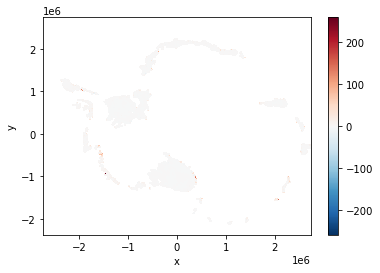

In [22]:
melt.coarsen(x=10, y=10, boundary="trim").mean().plot()

In [23]:
melt_coarse = melt.coarsen(x=2, y=2, boundary="trim").mean()

In [24]:
print(np.shape(melt.values))
print(np.shape(melt_coarse.values))

(10229, 10941)
(5114, 5470)


### get resolutions of data

In [25]:
resolution = (melt_coarse['x'][1]-melt_coarse['x'][0]).squeeze().astype(int).values
print(resolution)

1000


### plot coarsened data

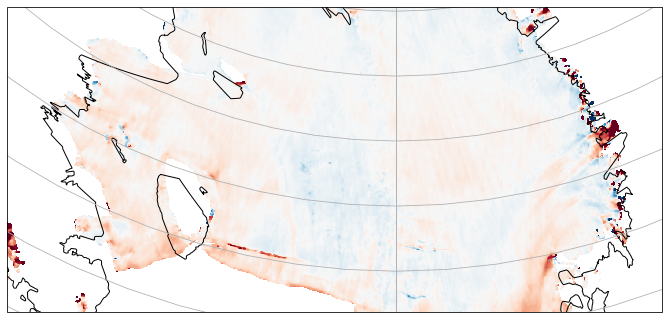

In [26]:
import cartopy.crs
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())

fig.subplots_adjust(bottom=0.05, top=0.95,
                    left=0.04, right=0.95, wspace=0.02)

ax.set_extent((160, 210, -82, -78), crs=cartopy.crs.PlateCarree())

ax.pcolormesh(melt_coarse['x'].squeeze(), melt_coarse['y'].squeeze(), 
              melt_coarse.values,
              vmin=-6, vmax=6, cmap='RdBu_r')


ax.coastlines(resolution='10m')

gl = ax.gridlines(draw_labels=False, xlocs=None, ylocs=None)
gl.n_steps = 90

# This bit of code sets a circular boundary for nice pan-polar figures
# theta = np.linspace(0, 2*np.pi, 100)
# center, radius = [0.5, 0.5], 0.5
# verts = np.vstack([np.sin(theta), np.cos(theta)]).T
# circle = mpath.Path(verts * radius + center)
# ax.set_boundary(circle, transform=ax.transAxes)

plt.show()




### write to ascii grid

In [76]:
#  need to flip data array

outvar = 'wb'
array_out = np.nan_to_num(np.flip(melt_coarse.values, 0), nan=-9999)
# array_out

In [82]:
# xllcorner    -2736000 
# yllcorner    -2740000

header = "ncols     %s\n" % array_out.shape[1]
header += "nrows    %s\n" % array_out.shape[0]
header += "xllcorner %s\n" % is_wb['x'][0].squeeze().astype(int)
header += "yllcorner %s\n" % is_wb['y'][0].squeeze().astype(int)
header += "cellsize %s\n" % resolution
header += "NODATA_value -9999\n"

np.savetxt(f"data/Adusumilli_2020_coarse-{resolution}m_{outvar}.asc", 
           array_out, header=header, comments='')#, fmt="%d")  #fmt="%1.2f")

## see what field are in the surface height change h5

In [36]:
filename ='ANT_iceshelf_height_changes_RA_1994_2018_v0.h5'
is_H = h5py.File(filename,'r')
list(is_H.keys())

['h_alt',
 'h_firn',
 'smb_discharge',
 'time',
 'uncert_alt',
 'uncert_firn',
 'x',
 'y']

### load each field 
also query size of a few of them to get an idea of how to write to xarray, below

In [32]:
h_alt = np.array(is_H['/h_alt'])
h_firn = np.array(is_H['/h_firn'])
smb_discharge = np.array(is_H['/smb_discharge'])
uncert_alt = np.array(is_H['/uncert_alt'])
uncert_firn = np.array(is_H['/uncert_firn'])

time = np.array(is_H['/time'])

h_firn = np.array(is_H['/h_firn'])
x_H = np.array(is_H['x'])
y_H = np.array(is_H['y'])

print(uncert_firn.shape)
print(h_firn.shape)
print(y_H.shape)
print(h_alt.shape)

(436, 510)
(107, 436, 510)
(436, 510)
(107, 436, 510)


### create an xarray dataarray for each field

In [53]:
h_alt_xr = xr.DataArray(h_alt, dims=("time","y", "x"), coords={"time": time[0,:],"y": y_H[:,0],"x": x_H[0,:]},name="h_alt") 
h_firn_xr = xr.DataArray(h_firn, dims=("time","y", "x"), coords={"time": time[0,:],"y": y_H[:,0],"x": x_H[0,:]},name="h_firn")   
smb_discharge_xr = xr.DataArray(smb_discharge, dims=("time","y", "x"), coords={"time": time[0,:],"y": y_H[:,0],"x": x_H[0,:]},name="smb_discharge")   
uncert_alt_xr = xr.DataArray(uncert_alt, dims=("time","y", "x"), coords={"time": time[0,:],"y": y_H[:,0],"x": x_H[0,:]},name="uncert_alt")   
uncert_firn_xr = xr.DataArray(uncert_firn, dims=("y", "x"), coords={"y": y_H[:,0],"x": x_H[0,:]},name="uncert_firn")   

### concatanate to one dataset

In [54]:
thickness_change = xr.merge([h_alt_xr, h_firn_xr, smb_discharge_xr, uncert_alt_xr, uncert_firn_xr])

In [55]:
thickness_change

<xarray.Dataset>
Dimensions:        (time: 107, x: 510, y: 436)
Coordinates:
  * time           (time) float64 1.992e+03 1.993e+03 ... 2.019e+03 2.019e+03
  * y              (y) float64 -2.12e+06 -2.11e+06 ... 2.22e+06 2.23e+06
  * x              (x) float64 -2.36e+06 -2.35e+06 ... 2.72e+06 2.73e+06
Data variables:
    h_alt          (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    h_firn         (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    smb_discharge  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    uncert_alt     (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    uncert_firn    (y, x) float64 nan nan nan nan nan ... nan nan nan nan nan

### plot one of the fields from a particular time to check it looks correct
this uses .sel to find the time slice closest to the year 2000

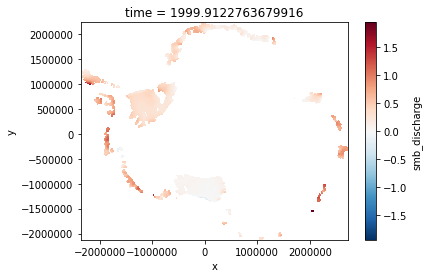

In [56]:
thickness_change.smb_discharge.sel(time=[2000],method="nearest").plot()

# write both to the google bucket

In [60]:
with open('/Users/jkingslake/Documents/science/ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)
gcs = gcsfs.GCSFileSystem(token=token)

In [62]:
mapper = gcs.get_mapper('ldeo-glaciology/subshelfmeltrates/adusumulli_2020/A2020_deltaH.zarr')
thickness_change.to_zarr(mapper, mode='w')

In [72]:
mapper = gcs.get_mapper('ldeo-glaciology/subshelfmeltrates/adusumulli_2020/A2020_meltrates.zarr')
ds = melt.to_dataset(name="meltrates")
ds.to_zarr(mapper, mode='w')